In [56]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.options.display.max_columns = None

In [57]:
gl_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-Game-Log.csv')
gl_19_20.insert(2, 'Season', '2019-2020')
gl_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Game-Log.csv')
gl_20_21.insert(2, 'Season', '2020-2021')
gl_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Game-Log.csv')
gl_21_22.insert(2, 'Season', '2021-2022')
gl_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Game-log.csv')
gl_22_23.insert(2, 'Season', '2022-2023')
gl_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Game-Log.csv')
gl_23_24.insert(2, 'Season', '2023-2024')

team_opp_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-PerGameTeamAndOpponentStats.csv')
team_opp_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Team&Opponent-Per-Game.csv')
team_opp_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Team&Opp-Per-Game.csv')
team_opp_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Team&Opponents.csv')
team_opp_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Team&Opp-Per-Game.csv')

roster_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-roster.csv')
roster_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Roster.csv')
roster_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Roster.csv')
roster_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Roster.csv')
roster_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Roster.csv')

In [58]:
# Correct the Win Streak and Lose Streak feature

def add_streak(game_log):
    # Ensure the Date column is in datetime format and sorted
    game_log['Date'] = pd.to_datetime(game_log['Date'])
    game_log = game_log.sort_values(by='Date').reset_index(drop=True)

    # Initialize streak columns
    win_streak = []
    lose_streak = []

    # Track streak counters
    current_win_streak = 0
    current_lose_streak = 0

    # Iterate over each row in the game log
    for _, row in game_log.iterrows():
        if row['Result'] == 'W':  # If the team won
            win_streak.append(current_win_streak)
            lose_streak.append(current_lose_streak)
            current_win_streak += 1
            current_lose_streak = 0
        else:  # If the team lost
            win_streak.append(current_win_streak)
            lose_streak.append(current_lose_streak)
            current_lose_streak += 1
            current_win_streak = 0

    # Add streak columns to the DataFrame
    game_log['Win Streak'] = win_streak
    game_log['Lose Streak'] = lose_streak

    return game_log

gl_19_20 = add_streak(gl_19_20)
gl_20_21 = add_streak(gl_20_21)
gl_21_20 = add_streak(gl_20_21)
gl_21_22 = add_streak(gl_21_22)
gl_22_23 = add_streak(gl_22_23)
gl_23_24 = add_streak(gl_23_24)

In [59]:
# Adding a feature that tells us how much rest the Fighting Illini had before their current game

def add_rest_time(game_log):
    # Ensure the Date column is in datetime format and sorted
    game_log['Date'] = pd.to_datetime(game_log['Date'])
    game_log = game_log.sort_values(by='Date').reset_index(drop=True)
    
    # Calculate rest days
    game_log['Rest Days'] = game_log['Date'].diff().dt.days.fillna(0).astype(int)
    
    # Fix any negative or unreasonable rest days
    game_log['Rest Days'] = game_log['Rest Days'].apply(lambda x: max(x, 0))  # No negative rest days

    # Insert Rest Days at the 7th index position
    game_log.insert(8, 'Rest Days', game_log.pop('Rest Days'))
    
    return game_log

gl_19_20 = add_rest_time(gl_19_20)
gl_20_21 = add_rest_time(gl_20_21)
gl_21_20 = add_rest_time(gl_20_21)
gl_21_22 = add_rest_time(gl_21_22)
gl_22_23 = add_rest_time(gl_22_23)
gl_23_24 = add_rest_time(gl_23_24)

In [60]:
# Adding a feature that calculates the rolling average of our stats

# List of statistical columns for which to calculate rolling averages
stats_columns = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%',
                 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 
                 'OPP FG', 'OPP FGA', 'OPP FG%', 'OPP 3P', 'OPP 3PA', 'OPP 3P%',
                 'OPP FT', 'OPP FTA', 'OPP FT%', 'OPP ORB', 'OPP TRB', 'OPP AST',
                 'OPP STL', 'OPP BLK', 'OPP TOV', 'OPP PF']

# Define a function to add rolling averages
def add_rolling_averages(df, window=5):
    for col in stats_columns:
        rolling_col_name = f"{col}_rolling_{window}"
        df[rolling_col_name] = df[col].rolling(window=window, min_periods=1).mean()
    return df

# Apply to each dataset
gl_19_20 = add_rolling_averages(gl_19_20)
gl_20_21 = add_rolling_averages(gl_20_21)
gl_21_22 = add_rolling_averages(gl_21_22)
gl_22_23 = add_rolling_averages(gl_22_23)
gl_23_24 = add_rolling_averages(gl_23_24)

In [61]:
all_gl = pd.concat([gl_19_20, gl_20_21, gl_21_22, gl_22_23, gl_23_24], ignore_index=True)
all_gl = all_gl.drop(columns='Unnamed: 0')
all_gl

Date    Time     Season    Type                 Opponent  Rank  \
0   2019-11-05   8:00p  2019-2020     REG           Nicholls State   NaN   
1   2019-11-08   9:00p  2019-2020     REG             Grand Canyon   NaN   
2   2019-11-10   9:00p  2019-2020     REG                  Arizona  21.0   
3   2019-11-18   8:00p  2019-2020     REG                   Hawaii   NaN   
4   2019-11-20   9:00p  2019-2020     REG              The Citadel   NaN   
5   2019-11-23   8:00p  2019-2020     REG                  Hampton   NaN   
6   2019-11-26   8:00p  2019-2020     REG               Lindenwood   NaN   
7   2019-12-02   7:00p  2019-2020     REG               Miami (FL)   NaN   
8   2019-12-07   5:00p  2019-2020     REG                 Maryland   3.0   
9   2019-12-11   9:00p  2019-2020     REG                 Michigan   5.0   
10  2019-12-14   6:00p  2019-2020     REG             Old Dominion   NaN   
11  2019-12-21   1:00p  2019-2020     REG                 Missouri   NaN   
12  2019-12-29   2:00p  2019-2020     REG       North Carolina A&T   NaN   
13  2020-01-02   8:00p  2019-2020     REG           Michigan State  14.0   
14  2020-01-05   8:00p  2019-2020     REG                   Purdue   NaN   
15  2020-01-08   9:00p  2019-2020     REG                Wisconsin   NaN   
16  2020-01-11  12:00p  2019-2020     REG                  Rutgers   NaN   
17  2020-01-18   5:00p  2019-2020     REG             Northwestern   NaN   
18  2020-01-21   7:00p  2019-2020     REG                   Purdue   NaN   
19  2020-01-25  12:00p  2019-2020     REG                 Michigan   NaN   
20  2020-01-30   7:30p  2019-2020     REG                Minnesota   NaN   
21  2020-02-02   1:00p  2019-2020     REG                     Iowa  18.0   
22  2020-02-07   8:00p  2019-2020     REG                 Maryland   9.0   
23  2020-02-11   9:00p  2019-2020     REG           Michigan State   NaN   
24  2020-02-15   4:30p  2019-2020     REG                  Rutgers   NaN   
25  2020-02-18   6:30p  2019-2020     REG               Penn State   9.0   
26  2020-02-24   8:00p  2019-2020     REG                 Nebraska   NaN   
27  2020-02-27   8:00p  2019-2020     REG             Northwestern   NaN   
28  2020-03-01   2:00p  2019-2020     REG                  Indiana   NaN   
29  2020-03-05   7:00p  2019-2020     REG               Ohio State  19.0   
30  2020-03-08   7:00p  2019-2020     REG                     Iowa  18.0   
31  2020-11-25   2:00p  2020-2021     REG       North Carolina A&T   NaN   
32  2020-11-26  12:00p  2020-2021     REG            Chicago State   NaN   
33  2020-11-27   1:00p  2020-2021     REG                     Ohio   NaN   
34  2020-12-02  10:00p  2020-2021     REG                   Baylor   2.0   
35  2020-12-08   9:30p  2020-2021     REG                     Duke  10.0   
36  2020-12-12   8:00p  2020-2021     REG                 Missouri   NaN   
37  2020-12-15   7:00p  2020-2021     REG                Minnesota   NaN   
38  2020-12-20   1:00p  2020-2021     REG                  Rutgers  19.0   
39  2020-12-23   6:30p  2020-2021     REG               Penn State   NaN   
40  2020-12-26   4:00p  2020-2021     REG                  Indiana   NaN   
41  2021-01-02   6:00p  2020-2021     REG                   Purdue   NaN   
42  2021-01-07   9:00p  2020-2021     REG             Northwestern   NaN   
43  2021-01-10   8:00p  2020-2021     REG                 Maryland   NaN   
44  2021-01-16  12:00p  2020-2021     REG               Ohio State  21.0   
45  2021-01-19   8:30p  2020-2021     REG               Penn State   NaN   
46  2021-01-29   9:00p  2020-2021     REG                     Iowa   7.0   
47  2021-02-02   9:00p  2020-2021     REG                  Indiana   NaN   
48  2021-02-06   2:30p  2020-2021     REG                Wisconsin  19.0   
49  2021-02-12   9:00p  2020-2021     REG                 Nebraska   NaN   
50  2021-02-16   9:00p  2020-2021     REG             Northwestern   NaN   
51  2021-02-20   3:30p  2020-2021     REG                M

In [62]:
# all_gl.to_csv(r'/Users/isaac/Desktop/personal/datadive24/Clean Datasets/All-Clean-Game-Logs.csv')

In [63]:
# Observe if Rest Days Were Correctly Calculated
all_gl['Rest Days'].unique()

array([ 0,  3,  2,  8,  6,  5,  4,  7,  1, 10, 13])

In [64]:
# Rename duplicate column names to be more concise
all_gl.rename(columns={'PF': 'Points For', 'PA' : 'Points Against', 'PF.1' : 'PF'}, inplace=True)
all_gl

Date    Time     Season    Type                 Opponent  Rank  \
0   2019-11-05   8:00p  2019-2020     REG           Nicholls State   NaN   
1   2019-11-08   9:00p  2019-2020     REG             Grand Canyon   NaN   
2   2019-11-10   9:00p  2019-2020     REG                  Arizona  21.0   
3   2019-11-18   8:00p  2019-2020     REG                   Hawaii   NaN   
4   2019-11-20   9:00p  2019-2020     REG              The Citadel   NaN   
5   2019-11-23   8:00p  2019-2020     REG                  Hampton   NaN   
6   2019-11-26   8:00p  2019-2020     REG               Lindenwood   NaN   
7   2019-12-02   7:00p  2019-2020     REG               Miami (FL)   NaN   
8   2019-12-07   5:00p  2019-2020     REG                 Maryland   3.0   
9   2019-12-11   9:00p  2019-2020     REG                 Michigan   5.0   
10  2019-12-14   6:00p  2019-2020     REG             Old Dominion   NaN   
11  2019-12-21   1:00p  2019-2020     REG                 Missouri   NaN   
12  2019-12-29   2:00p  2019-2020     REG       North Carolina A&T   NaN   
13  2020-01-02   8:00p  2019-2020     REG           Michigan State  14.0   
14  2020-01-05   8:00p  2019-2020     REG                   Purdue   NaN   
15  2020-01-08   9:00p  2019-2020     REG                Wisconsin   NaN   
16  2020-01-11  12:00p  2019-2020     REG                  Rutgers   NaN   
17  2020-01-18   5:00p  2019-2020     REG             Northwestern   NaN   
18  2020-01-21   7:00p  2019-2020     REG                   Purdue   NaN   
19  2020-01-25  12:00p  2019-2020     REG                 Michigan   NaN   
20  2020-01-30   7:30p  2019-2020     REG                Minnesota   NaN   
21  2020-02-02   1:00p  2019-2020     REG                     Iowa  18.0   
22  2020-02-07   8:00p  2019-2020     REG                 Maryland   9.0   
23  2020-02-11   9:00p  2019-2020     REG           Michigan State   NaN   
24  2020-02-15   4:30p  2019-2020     REG                  Rutgers   NaN   
25  2020-02-18   6:30p  2019-2020     REG               Penn State   9.0   
26  2020-02-24   8:00p  2019-2020     REG                 Nebraska   NaN   
27  2020-02-27   8:00p  2019-2020     REG             Northwestern   NaN   
28  2020-03-01   2:00p  2019-2020     REG                  Indiana   NaN   
29  2020-03-05   7:00p  2019-2020     REG               Ohio State  19.0   
30  2020-03-08   7:00p  2019-2020     REG                     Iowa  18.0   
31  2020-11-25   2:00p  2020-2021     REG       North Carolina A&T   NaN   
32  2020-11-26  12:00p  2020-2021     REG            Chicago State   NaN   
33  2020-11-27   1:00p  2020-2021     REG                     Ohio   NaN   
34  2020-12-02  10:00p  2020-2021     REG                   Baylor   2.0   
35  2020-12-08   9:30p  2020-2021     REG                     Duke  10.0   
36  2020-12-12   8:00p  2020-2021     REG                 Missouri   NaN   
37  2020-12-15   7:00p  2020-2021     REG                Minnesota   NaN   
38  2020-12-20   1:00p  2020-2021     REG                  Rutgers  19.0   
39  2020-12-23   6:30p  2020-2021     REG               Penn State   NaN   
40  2020-12-26   4:00p  2020-2021     REG                  Indiana   NaN   
41  2021-01-02   6:00p  2020-2021     REG                   Purdue   NaN   
42  2021-01-07   9:00p  2020-2021     REG             Northwestern   NaN   
43  2021-01-10   8:00p  2020-2021     REG                 Maryland   NaN   
44  2021-01-16  12:00p  2020-2021     REG               Ohio State  21.0   
45  2021-01-19   8:30p  2020-2021     REG               Penn State   NaN   
46  2021-01-29   9:00p  2020-2021     REG                     Iowa   7.0   
47  2021-02-02   9:00p  2020-2021     REG                  Indiana   NaN   
48  2021-02-06   2:30p  2020-2021     REG                Wisconsin  19.0   
49  2021-02-12   9:00p  2020-2021     REG                 Nebraska   NaN   
50  2021-02-16   9:00p  2020-2021     REG             Northwestern   NaN   
51  2021-02-20   3:30p  2020-2021     REG                M

In [65]:
all_gl.isna().sum()

Date                   0
Time                   0
Season                 0
Type                   0
Opponent               0
Rank                 120
Ranked Match           0
Conf                   1
Rest Days              0
SRS                    1
Result                 0
Points For             0
Points Against         0
W                      0
L                      0
Home Game              0
Win Streak             0
Lose Streak            0
FG                     0
FGA                    0
FG%                    0
3P                     0
3PA                    0
3P%                    0
FT                     0
FTA                    0
FT%                    0
ORB                    0
TRB                    0
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
OPP FG                 0
OPP FGA                0
OPP FG%                0
OPP 3P                 0
OPP 3PA                0
OPP 3P%                0


In [66]:
# Find the row with missing values
lindenwood = all_gl.loc[all_gl['Conf'].isna()]
lindenwood

Date   Time     Season Type    Opponent  Rank  Ranked Match Conf  \
6 2019-11-26  8:00p  2019-2020  REG  Lindenwood   NaN         False  NaN   

   Rest Days  SRS Result  Points For  Points Against  W  L  Home Game  \
6          3  NaN      W         117              65  6  1       True   

   Win Streak  Lose Streak  FG  FGA    FG%  3P  3PA   3P%  FT  FTA    FT%  \
6           3            0  39   63  0.619  11   25  0.44  28   37  0.757   

   ORB  TRB  AST  STL  BLK  TOV  PF  OPP FG  OPP FGA  OPP FG%  OPP 3P  \
6   10   39   25   13    4   14  13      25       64    0.391      11   

   OPP 3PA  OPP 3P%  OPP FT  OPP FTA  OPP FT%  OPP ORB  OPP TRB  OPP AST  \
6       30    0.367       4        5      0.8        7       22       10   

   OPP STL  OPP BLK  OPP TOV  OPP PF  FG_rolling_5  FGA_rolling_5  \
6       10        0       24      30          33.0           61.6   

   FG%_rolling_5  3P_rolling_5  3PA_rolling_5  3P%_rolling_5  FT_rolling_5  \
6          0.529           6.4           17.8         0.3562          19.0   

   FTA_rolling_5  FT%_rolling_5  ORB_rolling_5  TRB_rolling_5  AST_rolling_5  \
6           25.6         0.7372           12.0           40.2           19.0   

   STL_rolling_5  BLK_rolling_5  TOV_rolling_5  PF_rolling_5  \
6            6.6            2.8           14.6          91.4   

   OPP FG_rolling_5  OPP FGA_rolling_5  OPP FG%_rolling_5  OPP 3P_rolling_5  \
6              26.4               65.4              0.409               7.4   

   OPP 3PA_rolling_5  OPP 3P%_rolling_5  OPP FT_rolling_5  OPP FTA_rolling_5  \
6               24.4             0.3158               7.0               10.2   

   OPP FT%_rolling_5  OPP ORB_rolling_5  OPP TRB_rolling_5  OPP AST_rolling_5  \
6             0.7012                8.6               25.0               12.2   

   OPP STL_rolling_5  OPP BLK_rolling_5  OPP TOV_rolling_5  OPP PF_rolling_5  
6                8.4                1.4               15.2              22.2

In [67]:
# Fill in missing conference value
lindenwood['Conf'] = 'OVC'
lindenwood

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/294574576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindenwood['Conf'] = 'OVC'


Date   Time     Season Type    Opponent  Rank  Ranked Match Conf  \
6 2019-11-26  8:00p  2019-2020  REG  Lindenwood   NaN         False  OVC   

   Rest Days  SRS Result  Points For  Points Against  W  L  Home Game  \
6          3  NaN      W         117              65  6  1       True   

   Win Streak  Lose Streak  FG  FGA    FG%  3P  3PA   3P%  FT  FTA    FT%  \
6           3            0  39   63  0.619  11   25  0.44  28   37  0.757   

   ORB  TRB  AST  STL  BLK  TOV  PF  OPP FG  OPP FGA  OPP FG%  OPP 3P  \
6   10   39   25   13    4   14  13      25       64    0.391      11   

   OPP 3PA  OPP 3P%  OPP FT  OPP FTA  OPP FT%  OPP ORB  OPP TRB  OPP AST  \
6       30    0.367       4        5      0.8        7       22       10   

   OPP STL  OPP BLK  OPP TOV  OPP PF  FG_rolling_5  FGA_rolling_5  \
6       10        0       24      30          33.0           61.6   

   FG%_rolling_5  3P_rolling_5  3PA_rolling_5  3P%_rolling_5  FT_rolling_5  \
6          0.529           6.4           17.8         0.3562          19.0   

   FTA_rolling_5  FT%_rolling_5  ORB_rolling_5  TRB_rolling_5  AST_rolling_5  \
6           25.6         0.7372           12.0           40.2           19.0   

   STL_rolling_5  BLK_rolling_5  TOV_rolling_5  PF_rolling_5  \
6            6.6            2.8           14.6          91.4   

   OPP FG_rolling_5  OPP FGA_rolling_5  OPP FG%_rolling_5  OPP 3P_rolling_5  \
6              26.4               65.4              0.409               7.4   

   OPP 3PA_rolling_5  OPP 3P%_rolling_5  OPP FT_rolling_5  OPP FTA_rolling_5  \
6               24.4             0.3158               7.0               10.2   

   OPP FT%_rolling_5  OPP ORB_rolling_5  OPP TRB_rolling_5  OPP AST_rolling_5  \
6             0.7012                8.6               25.0               12.2   

   OPP STL_rolling_5  OPP BLK_rolling_5  OPP TOV_rolling_5  OPP PF_rolling_5  
6                8.4                1.4               15.2              22.2

In [68]:
# Fill in missing SRS value with an estimate
lindenwood['SRS'] = 42
lindenwood

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/1554679363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindenwood['SRS'] = 42


Date   Time     Season Type    Opponent  Rank  Ranked Match Conf  \
6 2019-11-26  8:00p  2019-2020  REG  Lindenwood   NaN         False  OVC   

   Rest Days  SRS Result  Points For  Points Against  W  L  Home Game  \
6          3   42      W         117              65  6  1       True   

   Win Streak  Lose Streak  FG  FGA    FG%  3P  3PA   3P%  FT  FTA    FT%  \
6           3            0  39   63  0.619  11   25  0.44  28   37  0.757   

   ORB  TRB  AST  STL  BLK  TOV  PF  OPP FG  OPP FGA  OPP FG%  OPP 3P  \
6   10   39   25   13    4   14  13      25       64    0.391      11   

   OPP 3PA  OPP 3P%  OPP FT  OPP FTA  OPP FT%  OPP ORB  OPP TRB  OPP AST  \
6       30    0.367       4        5      0.8        7       22       10   

   OPP STL  OPP BLK  OPP TOV  OPP PF  FG_rolling_5  FGA_rolling_5  \
6       10        0       24      30          33.0           61.6   

   FG%_rolling_5  3P_rolling_5  3PA_rolling_5  3P%_rolling_5  FT_rolling_5  \
6          0.529           6.4           17.8         0.3562          19.0   

   FTA_rolling_5  FT%_rolling_5  ORB_rolling_5  TRB_rolling_5  AST_rolling_5  \
6           25.6         0.7372           12.0           40.2           19.0   

   STL_rolling_5  BLK_rolling_5  TOV_rolling_5  PF_rolling_5  \
6            6.6            2.8           14.6          91.4   

   OPP FG_rolling_5  OPP FGA_rolling_5  OPP FG%_rolling_5  OPP 3P_rolling_5  \
6              26.4               65.4              0.409               7.4   

   OPP 3PA_rolling_5  OPP 3P%_rolling_5  OPP FT_rolling_5  OPP FTA_rolling_5  \
6               24.4             0.3158               7.0               10.2   

   OPP FT%_rolling_5  OPP ORB_rolling_5  OPP TRB_rolling_5  OPP AST_rolling_5  \
6             0.7012                8.6               25.0               12.2   

   OPP STL_rolling_5  OPP BLK_rolling_5  OPP TOV_rolling_5  OPP PF_rolling_5  
6                8.4                1.4               15.2              22.2

In [69]:
all_gl.loc[all_gl['Conf'].isna()] = lindenwood

In [70]:
all_gl.isna().sum()

Date                   0
Time                   0
Season                 0
Type                   0
Opponent               0
Rank                 120
Ranked Match           0
Conf                   0
Rest Days              0
SRS                    0
Result                 0
Points For             0
Points Against         0
W                      0
L                      0
Home Game              0
Win Streak             0
Lose Streak            0
FG                     0
FGA                    0
FG%                    0
3P                     0
3PA                    0
3P%                    0
FT                     0
FTA                    0
FT%                    0
ORB                    0
TRB                    0
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
OPP FG                 0
OPP FGA                0
OPP FG%                0
OPP 3P                 0
OPP 3PA                0
OPP 3P%                0


/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/1866265331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])


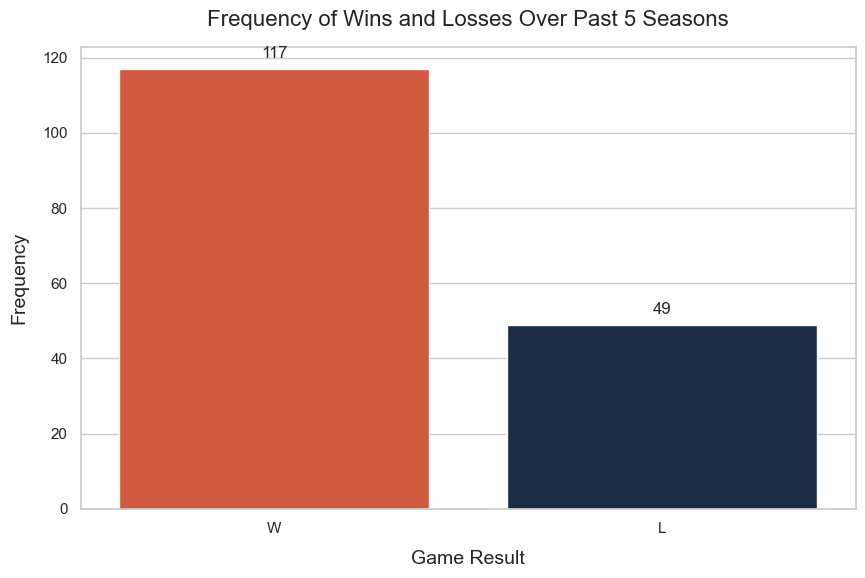

In [71]:
# Calculate the result counts
result_counts = all_gl['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Frequency of Wins and Losses Over Past 5 Seasons', fontsize=16, pad=15)

# Adding value annotations on top of the bars
for index, row in result_counts.iterrows():
    plt.text(row.name, row.Frequency + 2, row.Frequency, ha='center', va='bottom', fontsize=12)

plt.show()


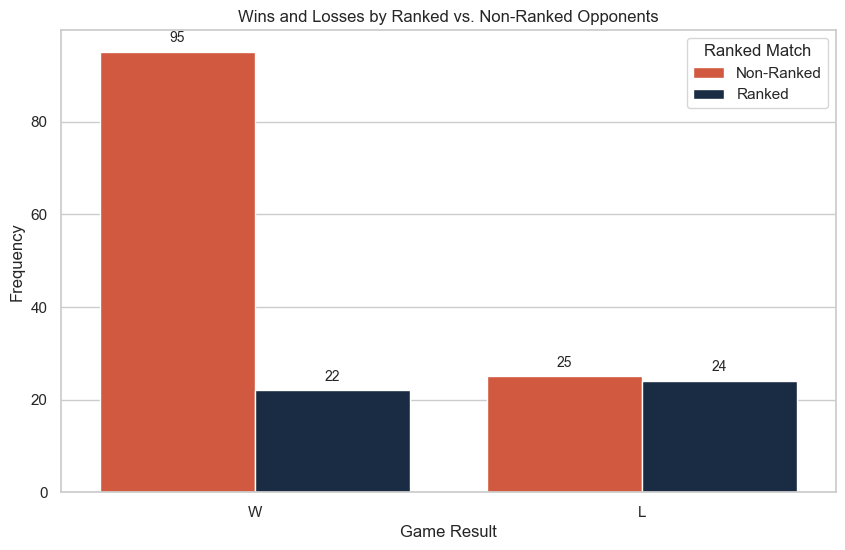

In [72]:
# Observe how well we do against ranked teams
plt.figure(figsize=(10, 6))

# Create a grouped bar plot using 'Result' and 'Ranked Match' columns
plot = sns.countplot(data=all_gl, x='Result', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds count at the top of the bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

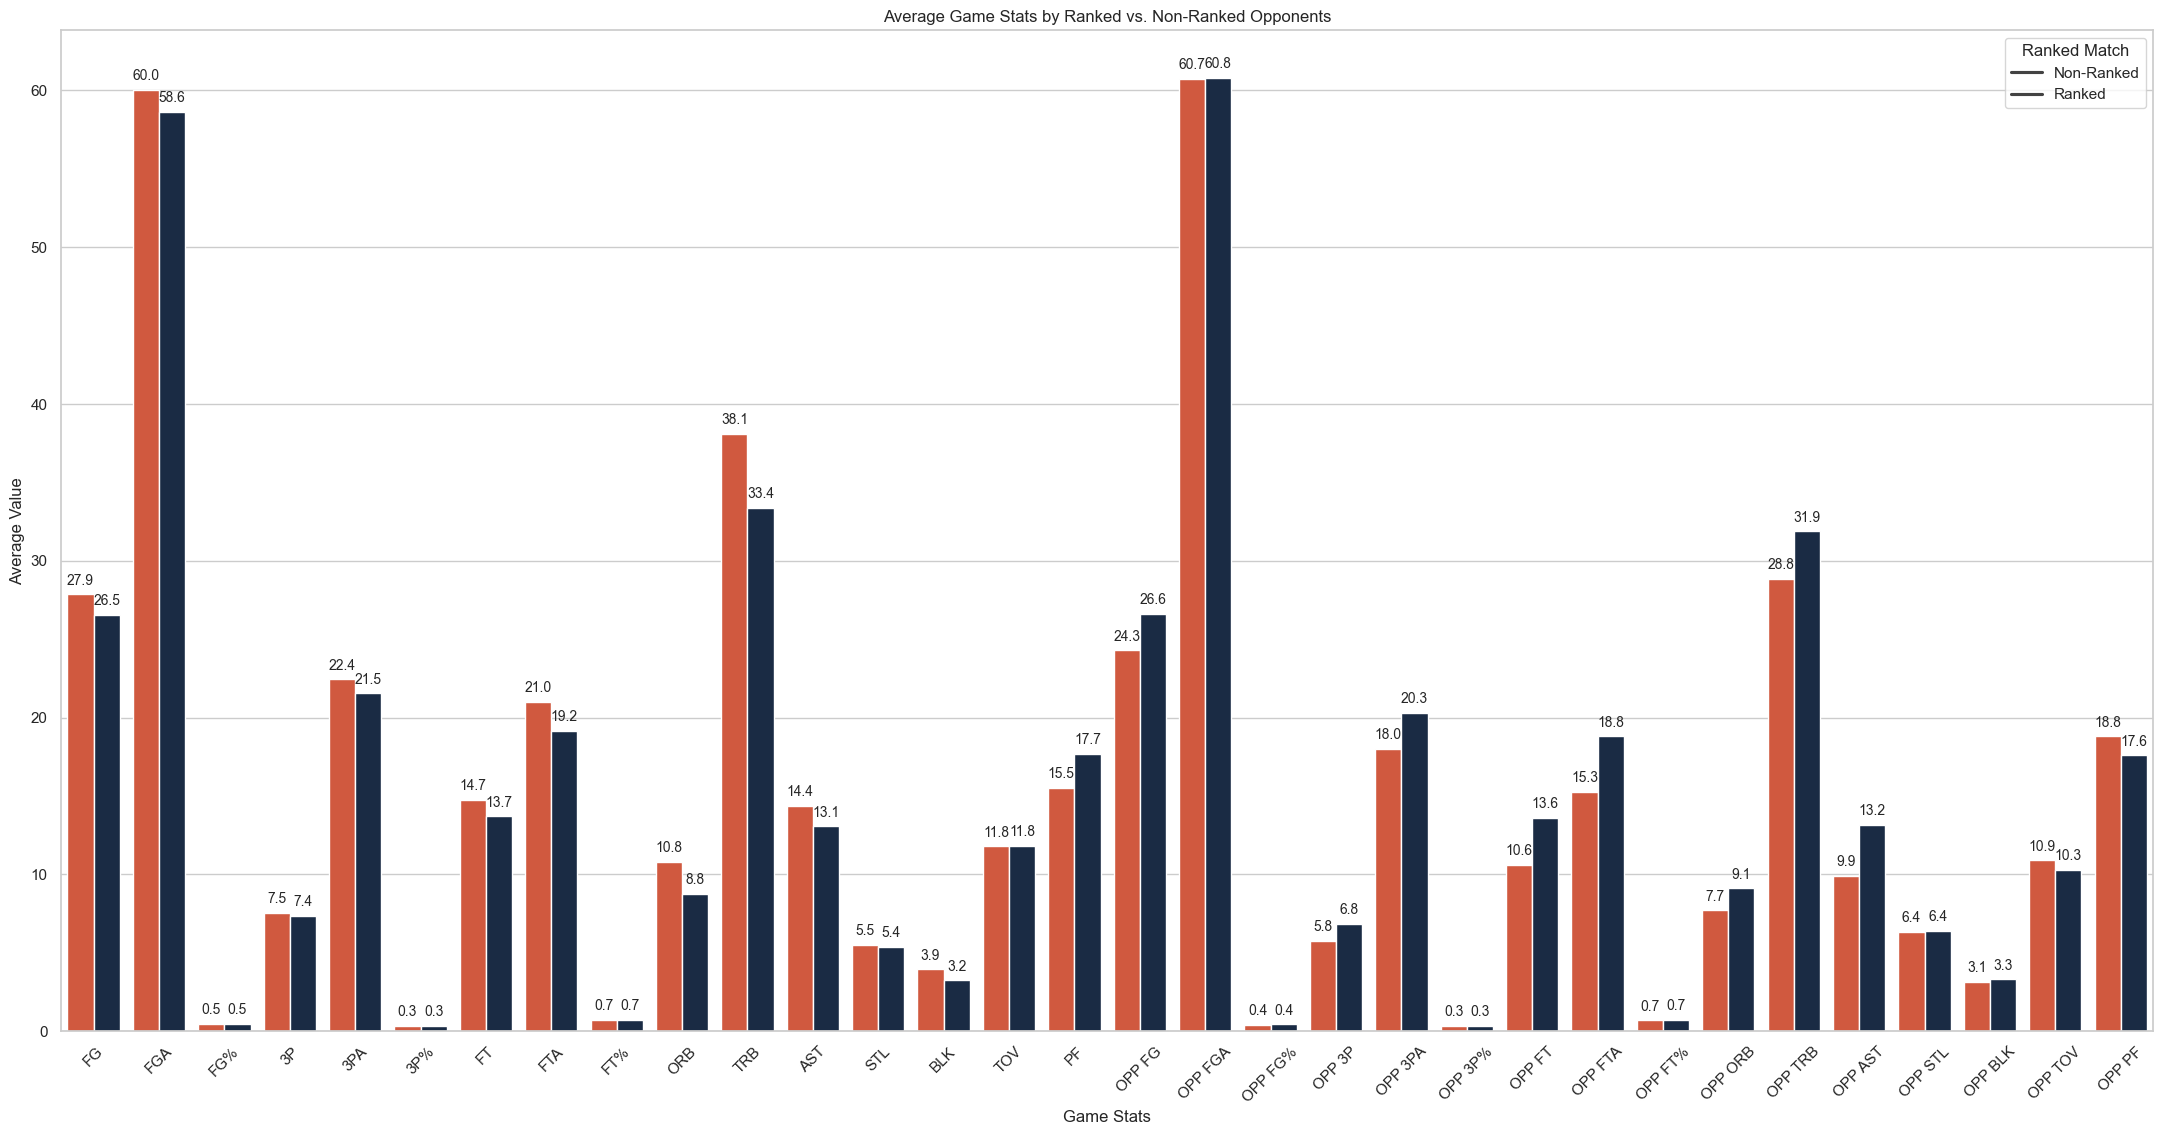

In [73]:
stats = [
    'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
    'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 
    'OPP FG', 'OPP FGA', 'OPP FG%', 'OPP 3P', 'OPP 3PA', 'OPP 3P%', 
    'OPP FT', 'OPP FTA', 'OPP FT%', 'OPP ORB', 'OPP TRB', 
    'OPP AST', 'OPP STL', 'OPP BLK', 'OPP TOV', 'OPP PF'
]

# Calculate the mean of each stat grouped by 'Ranked Match'
avg_stats = all_gl.groupby('Ranked Match')[stats].mean().reset_index()

# Reshape the data to have each stat as a separate entry for grouped plotting
avg_stats_melted = avg_stats.melt(id_vars='Ranked Match', var_name='Stat', value_name='Average')

plt.figure(figsize=(27, 13))
plot = sns.barplot(data=avg_stats_melted, x='Stat', y='Average', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Stats')
plt.ylabel('Average Value')
plt.title('Average Game Stats by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds average value at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, fmt="%.1f", label_type='edge', padding=5, fontsize=10)

plt.xticks(rotation=45)
plt.show()

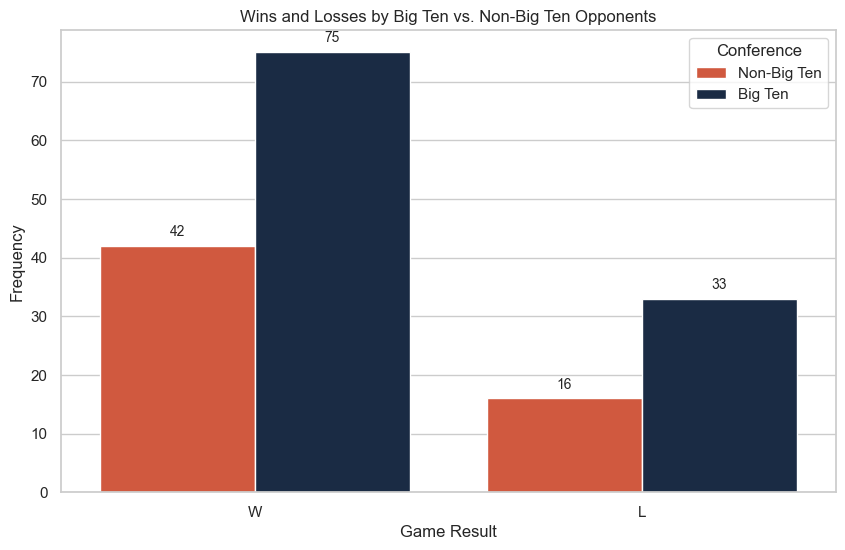

In [74]:
# What about for Conference vs. Non-Conference games
conf_gl = all_gl.copy()

conf_gl['Big_Ten_Opponent'] = conf_gl['Conf'].apply(lambda x: 'Big Ten' if x == 'Big Ten' else 'Non-Big Ten')

plt.figure(figsize=(10, 6))

plot = sns.countplot(data=conf_gl, x='Result', hue='Big_Ten_Opponent', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Big Ten vs. Non-Big Ten Opponents')
plt.legend(title='Conference', labels=['Non-Big Ten', 'Big Ten'])

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

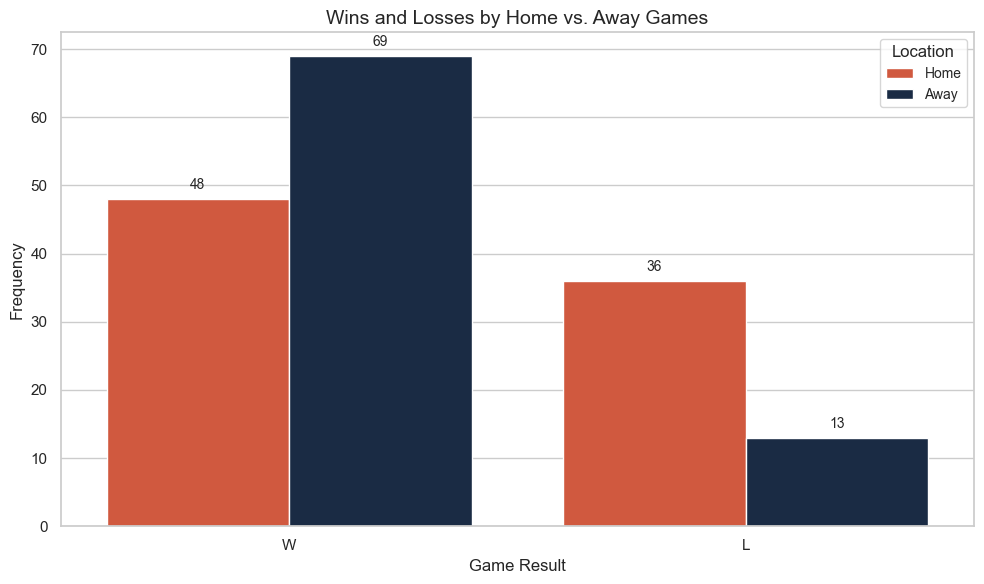

In [75]:
# What about for Home vs. Away games
plt.figure(figsize=(10, 6))

plot = sns.countplot(data=all_gl, x='Result', hue='Home Game', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Wins and Losses by Home vs. Away Games', fontsize=14)
plt.legend(title='Location', labels=['Home', 'Away'], fontsize=10)

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

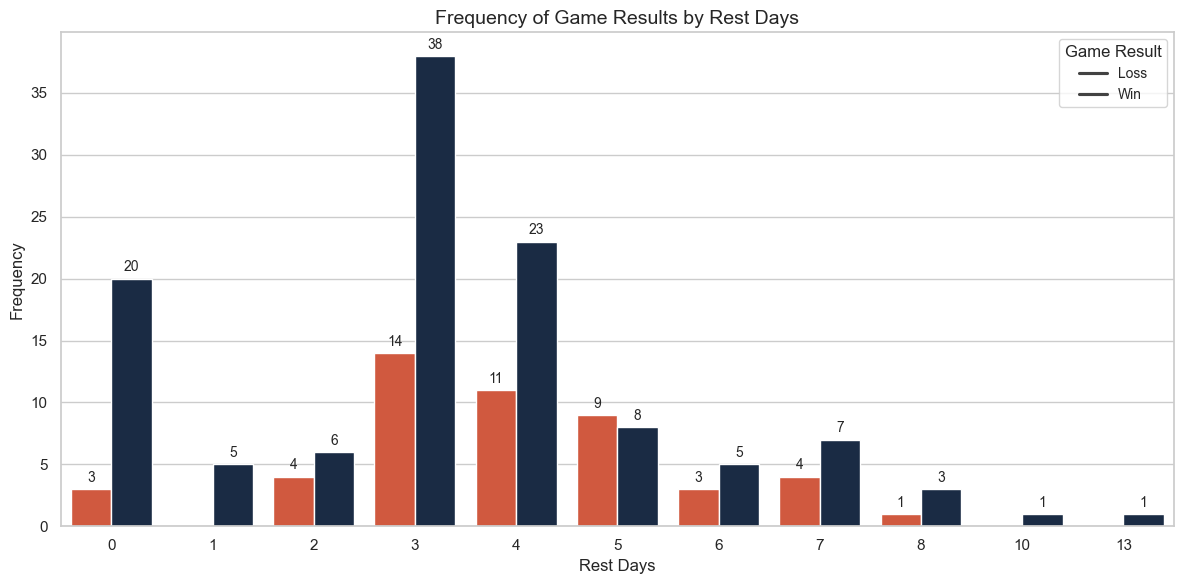

In [76]:
# Observe how the relationship between rest days and game results
plt.figure(figsize=(12, 6))

# Group data by Rest Days and Result, then count occurrences
rest_days_result = all_gl.groupby(['Rest Days', 'Result']).size().reset_index(name='Frequency')

plot = sns.barplot(data=rest_days_result, x='Rest Days', y='Frequency', hue='Result', palette=['#E84A27', '#13294b'])

plt.xlabel('Rest Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of Game Results by Rest Days', fontsize=14)
plt.legend(title='Game Result', labels=['Loss', 'Win'], fontsize=10)

# Add value labels to each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

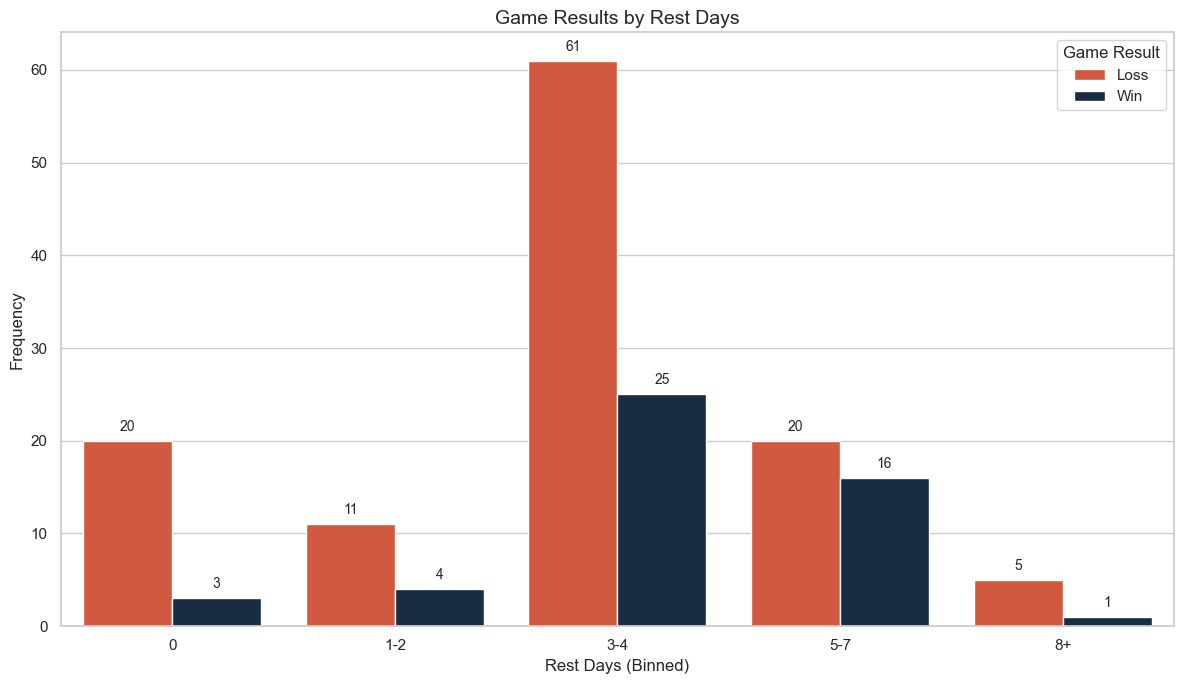

In [77]:
# Create bins for Rest Days and apply to our graph to better observe any trends
bins = [0, 1, 3, 5, 8, 100] 
labels = ['0', '1-2', '3-4', '5-7', '8+'] 
all_gl['Rest_Days_Binned'] = pd.cut(all_gl['Rest Days'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 7))

plot = sns.countplot(data=all_gl, x='Rest_Days_Binned', hue='Result', palette=['#E84A27', '#13294b'])

plt.xlabel('Rest Days (Binned)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Game Results by Rest Days', fontsize=14)
plt.legend(title='Game Result', labels=['Loss', 'Win'])

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

In [78]:
# show the teams we have highest chance of winning against from lowest to highest

big_ten_schools = conf_gl[conf_gl['Big_Ten_Opponent'] == 'Big Ten']

big_ten_matchups = big_ten_schools.groupby('Opponent').agg(Total_Games=('Opponent', 'size'), 
    Wins=('Result', lambda x: (x == 'W').sum())).reset_index()

big_ten_matchups['Win Percentage'] = (big_ten_matchups['Wins'] / big_ten_matchups['Total_Games']) * 100

big_ten_matchups_sorted = big_ten_matchups.sort_values(by='Win Percentage', ascending=False)

big_ten_matchups_sorted

Opponent  Total_Games  Wins  Win Percentage
3         Michigan            8     8      100.000000
5        Minnesota            7     7      100.000000
6         Nebraska            8     8      100.000000
12       Wisconsin            8     8      100.000000
7     Northwestern           10     8       80.000000
1             Iowa            9     7       77.777778
11         Rutgers            9     6       66.666667
0          Indiana            8     5       62.500000
8       Ohio State            9     5       55.555556
4   Michigan State            8     4       50.000000
9       Penn State            8     4       50.000000
10          Purdue            8     3       37.500000
2         Maryland            8     2       25.000000

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/930791426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])
/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/930791426.py:3: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])


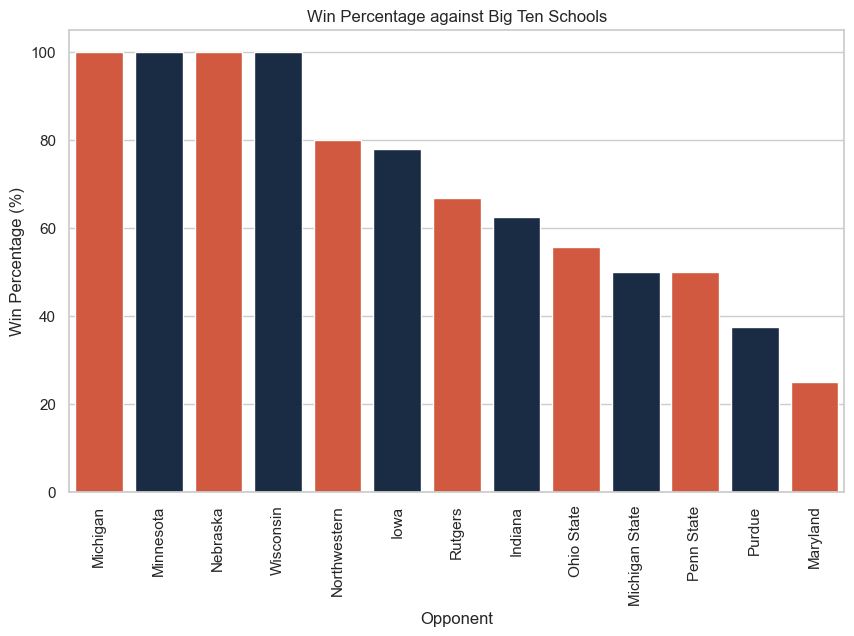

In [79]:
plt.figure(figsize=(10, 6))

sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])

plt.title('Win Percentage against Big Ten Schools')
plt.xlabel('Opponent')
plt.ylabel('Win Percentage (%)')
plt.xticks(rotation=90)

plt.show()

In [80]:
# Make a numeric only game log data frame for our correlation matrix
num_gl = all_gl.copy()
num_gl['Result'] = num_gl['Result'].apply(lambda x: 1 if x == 'W' else 0)
num_gl['Ranked Match'] = num_gl['Ranked Match'].apply(lambda x: 1 if x == True else 0)
num_gl['Home Game'] = num_gl['Home Game'].apply(lambda x: 1 if x == True else 0)
num_gl['Type'] = num_gl['Type'].astype('category').cat.codes
num_gl['Conf'] = num_gl['Conf'].astype('category').cat.codes
num_gl = num_gl.drop(columns=['Season','Date','Time','Rank','Opponent', 'Rest_Days_Binned'])
num_gl

Type  Ranked Match  Conf  Rest Days    SRS  Result  Points For  \
0       2             0    21          0  -3.87       1          78   
1       2             0    24          3  -6.32       1          83   
2       2             1    16          2  19.49       0          69   
3       2             0     7          8  -1.27       1          66   
4       2             0    20          2 -13.82       1          85   
5       2             0     5          3 -12.02       1         120   
6       2             0    15          3  42.00       1         117   
7       2             0     2          6   6.63       0          79   
8       2             1     6          5  17.82       0          58   
9       2             1     6          4  17.94       1          71   
10      2             0     9          3   0.02       1          69   
11      2             0    18          7   8.51       0          56   
12      2             0    12          8  -9.66       1          95   
13      2             1     6          4  21.92       0          56   
14      2             0     6          3  16.30       1          63   
15      2             0     6          3  15.95       1          71   
16      2             0     6          3  15.72       1          54   
17      2             0     6          7   5.35       1          75   
18      2             0     6          3  16.30       1          79   
19      2             0     6          4  17.94       1          64   
20      2             0     6          5  16.39       1          59   
21      2             1     6          3  16.07       0          65   
22      2             1     6          5  17.82       0          66   
23      2             0     6          4  21.92       0          69   
24      2             0     6          4  15.72       0          57   
25      2             1     6          3  16.12       1          62   
26      2             0     6          6   2.41       1          71   
27      2             0     6          3   5.35       1          74   
28      2             0     6          3  15.07       1          67   
29      2             1     6          4  19.37       0          63   
30      2             1     6          3  16.07       1          78   
31      2             0    12          0 -14.27       1         122   
32      2             0    24          1 -31.82       1          97   
33      2             0    11          1   5.48       1          77   
34      2             1     3          5  24.83       0          69   
35      2             1     2          6  13.04       1          83   
36      2             0    18          4  12.37       0          78   
37      2             0     6          3  11.04       1          92   
38      2             1     6          5  14.14       0          88   
39      2             0     6          3  13.53       1          98   
40      2             0     6          3  12.79       1          69   
41      2             0     6          7  15.55       1          66   
42      2             0     6          5   9.71       1          81   
43      2             0     6          3  13.94       0          63   
44      2             1     6          6  18.25       0          81   
45      2             0     6          3  13.53       1          79   
46      2             1     6         10  21.40       1          80   
47      2             0     6          4  12.79       1          75   
48      2             1     6          4  17.22       1          75   
49      2             0     6          6   6.08       1          77   
50      2             0     6          4   9.71       1          73   
51      2             0     6          4  11.04       1          94   
52      2             0     6          3   9.80       0          72   
53      2             0     6          2   6.08       1          86   
54      2             1     6          2  17.22       1          74   
55      2             1     6

In [81]:
# Create correlation matrix
gl_corr = num_gl.corr()
gl_corr

Type  Ranked Match      Conf  Rest Days       SRS  \
Type               1.000000     -0.030473  0.063755   0.003785 -0.143599   
Ranked Match      -0.030473      1.000000 -0.210393   0.016763  0.494297   
Conf               0.063755     -0.210393  1.000000  -0.035911 -0.544133   
Rest Days          0.003785      0.016763 -0.035911   1.000000  0.037103   
SRS               -0.143599      0.494297 -0.544133   0.037103  1.000000   
Result             0.017303     -0.307529  0.116823  -0.128093 -0.368844   
Points For        -0.013791     -0.215956  0.213062  -0.168776 -0.360192   
Points Against    -0.122046      0.256143 -0.204840  -0.041059  0.430328   
W                 -0.505196      0.132115 -0.384889   0.067538  0.402195   
L                 -0.378055      0.140660 -0.365990   0.173772  0.415786   
Home Game          0.314180     -0.154066  0.168556  -0.013744 -0.333310   
Win Streak        -0.236169      0.125882 -0.162264  -0.095829  0.284201   
Lose Streak        0.058912      0.041010 -0.052377   0.104651 -0.002323   
FG                -0.026278     -0.111847  0.181597  -0.144395 -0.368120   
FGA               -0.019801     -0.098878  0.059481  -0.139777 -0.192892   
FG%               -0.004968     -0.053695  0.162790  -0.080988 -0.284552   
3P                 0.075497     -0.024221  0.034688  -0.067614 -0.147101   
3PA                0.107015     -0.063622  0.076679  -0.099775 -0.126318   
3P%                0.012197      0.058443 -0.087367   0.003695 -0.030999   
FT                -0.132161     -0.095936  0.170722  -0.109510 -0.004202   
FTA               -0.122136     -0.133440  0.232898  -0.140650 -0.077079   
FT%               -0.040119      0.053505 -0.052210   0.033348  0.111942   
ORB                0.003853     -0.237245  0.214734  -0.129832 -0.320031   
TRB                0.057074     -0.276419  0.232544  -0.126534 -0.414009   
AST               -0.104227     -0.129529  0.095488  -0.012564 -0.283359   
STL               -0.033579     -0.016590  0.204666   0.035006 -0.144274   
BLK                0.009428     -0.139170  0.063254   0.085675 -0.176202   
TOV                0.121214      0.003965  0.340438   0.005459 -0.171348   
PF                 0.009221      0.231487 -0.063584   0.023794  0.190419   
OPP FG            -0.102009      0.236536 -0.156109  -0.074224  0.334399   
OPP FGA           -0.039764      0.003568  0.103235  -0.108199 -0.024953   
OPP FG%           -0.081075      0.230974 -0.210905  -0.017839  0.340709   
OPP 3P            -0.019613      0.195680 -0.053509  -0.020204  0.161204   
OPP 3PA            0.035311      0.196681  0.077512  -0.056667  0.005666   
OPP 3P%           -0.023185      0.061795 -0.112558   0.015238  0.155047   
OPP FT            -0.041117      0.222718 -0.098696  -0.013468  0.228819   
OPP FTA           -0.014437      0.209847 -0.095279  -0.017523  0.203914   
OPP FT%           -0.143995      0.073223 -0.075984  -0.023268  0.122284   
OPP ORB           -0.013960      0.191592  0.006091   0.012553  0.176437   
OPP TRB           -0.053442      0.209267 -0.180549   0.018288  0.321177   
OPP AST           -0.104331      0.336671 -0.124995  -0.069879  0.257056   
OPP STL            0.049641      0.008429  0.265853   0.019564 -0.068390   
OPP BLK           -0.015048      0.036074 -0.122097   0.096987  0.130059   
OPP TOV            0.076969     -0.071495  0.350028   0.027661 -0.240649   
OPP PF            -0.045986     -0.143821  0.298049  -0.114252 -0.095286   
FG_rolling_5      -0.056260     -0.045660  0.146056  -0.160808 -0.214328   
FGA_rolling_5     -0.021647     -0.139050  0.121679  -0.225823 -0.257567   
FG%_rolling_5     -0.054841      0.024497  0.110416  -0.074327 -0.109647   
3P_rolling_5       0.034368     -0.087834  0.083219  -0.083600 -0.223764   
3PA_rolling_5      0.109720     -0.124593  0.082165  -0.096633 -0.222431   
3P%_rolling_5     -0.099762      0.024726 -0.015912  -0.038237 -0.024195   
FT_rolling_5      -0.253041     -0.005628  0.204980  -0.062983 -0.04752

In [82]:
# The variables that have the most affect on the Result column in order
pd.set_option('display.max_rows', None)
result_corr = gl_corr['Result'].drop('Result')
result_corr = result_corr.abs().sort_values(ascending=False)
result_corr = result_corr.reset_index()
result_corr.columns = ['Variable', 'Correlation with Result']
result_corr

Variable  Correlation with Result
0      Points Against                 0.488643
1             OPP FG%                 0.471648
2                 FG%                 0.420372
3          Points For                 0.404264
4              OPP FT                 0.386908
5                 SRS                 0.368844
6                 TRB                 0.360312
7             OPP FTA                 0.357548
8                  FG                 0.353430
9              OPP FG                 0.317650
10       Ranked Match                 0.307529
11                AST                 0.297493
12          Home Game                 0.295989
13                FTA                 0.258117
14            OPP TRB                 0.255935
15                 PF                 0.241891
16  OPP FG%_rolling_5                 0.241337
17                 FT                 0.235833
18            OPP FGA                 0.234166
19            OPP 3P%                 0.231392
20            OPP AST                 0.219161
21                  L                 0.205387
22      TRB_rolling_5                 0.193769
23       PF_rolling_5                 0.190963
24             OPP PF                 0.188236
25                3P%                 0.186786
26  OPP FGA_rolling_5                 0.182158
27      3P%_rolling_5                 0.178922
28       FG_rolling_5                 0.172917
29      AST_rolling_5                 0.172371
30      FG%_rolling_5                 0.163673
31            OPP BLK                 0.156929
32         Win Streak                 0.153223
33       3P_rolling_5                 0.151168
34            OPP FT%                 0.145007
35            OPP STL                 0.139569
36  OPP FT%_rolling_5                 0.133209
37             OPP 3P                 0.132209
38          Rest Days                 0.128093
39  OPP AST_rolling_5                 0.119276
40               Conf                 0.116823
41                3PA                 0.115719
42                BLK                 0.114587
43            OPP ORB                 0.114162
44      ORB_rolling_5                 0.111011
45      FGA_rolling_5                 0.110073
46   OPP FT_rolling_5                 0.108885
47   OPP FG_rolling_5                 0.108275
48   OPP PF_rolling_5                 0.108096
49  OPP 3P%_rolling_5                 0.093723
50   OPP 3P_rolling_5                 0.088212
51  OPP TRB_rolling_5                 0.086601
52      FTA_rolling_5                 0.084561
53            OPP 3PA                 0.079264
54  OPP FTA_rolling_5                 0.076041
55      FT%_rolling_5                 0.074297
56                STL                 0.066848
57      3PA_rolling_5                 0.056952
58                 3P                 0.053406
59       FT_rolling_5                 0.048395
60                TOV                 0.046704
61  OPP STL_rolling_5                 0.045391
62            OPP TOV                 0.043027
63  OPP BLK_rolling_5                 0.042194
64      TOV_rolling_5                 0.039791
65                ORB                 0.037808
66      BLK_rolling_5                 0.036738
67      STL_rolling_5                 0.031727
68                  W                 0.028972
69  OPP ORB_rolling_5                 0.023018
70        Lose Streak                 0.019311
71               Type                 0.017303
72                FGA                 0.015423
73                FT%                 0.006880
74  OPP TOV_rolling_5                 0.006260
75  OPP 3PA_rolling_5                 0.005239

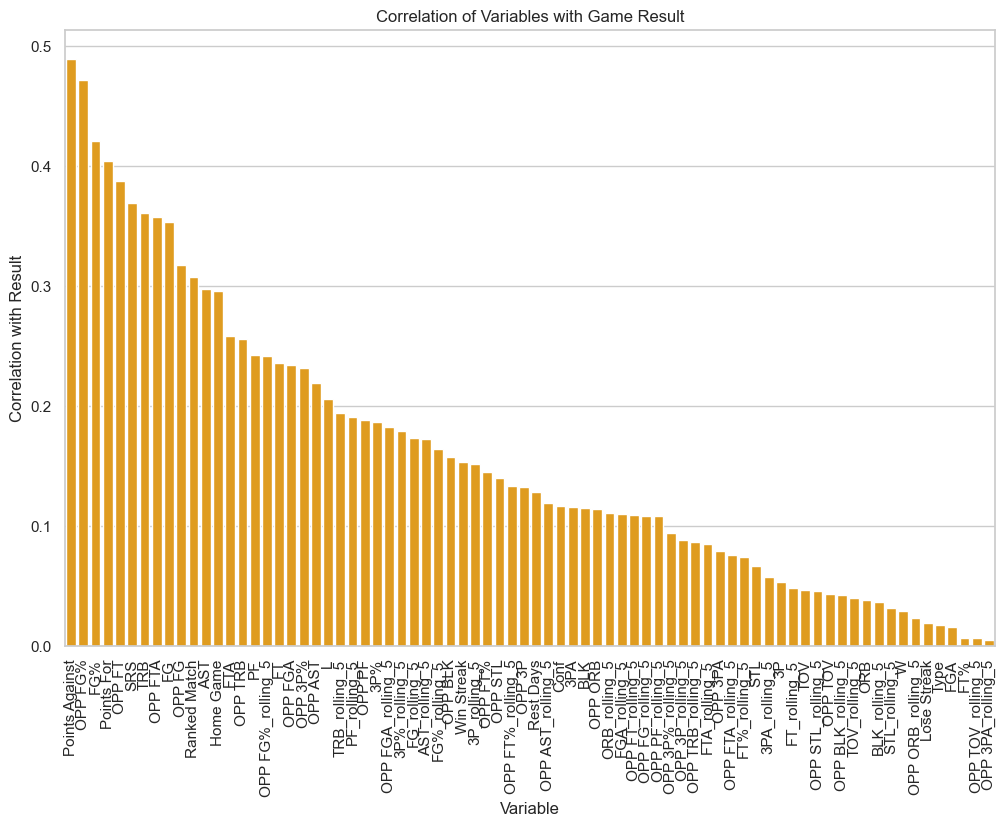

In [83]:
# Visualization to easily view what variables had the highest correlation with result
plt.figure(figsize=(12, 8))
sns.barplot(data=result_corr, x='Variable', y='Correlation with Result', color='orange')
plt.xticks(rotation=90)
plt.title('Correlation of Variables with Game Result')
plt.xlabel('Variable')
plt.ylabel('Correlation with Result')
plt.show()

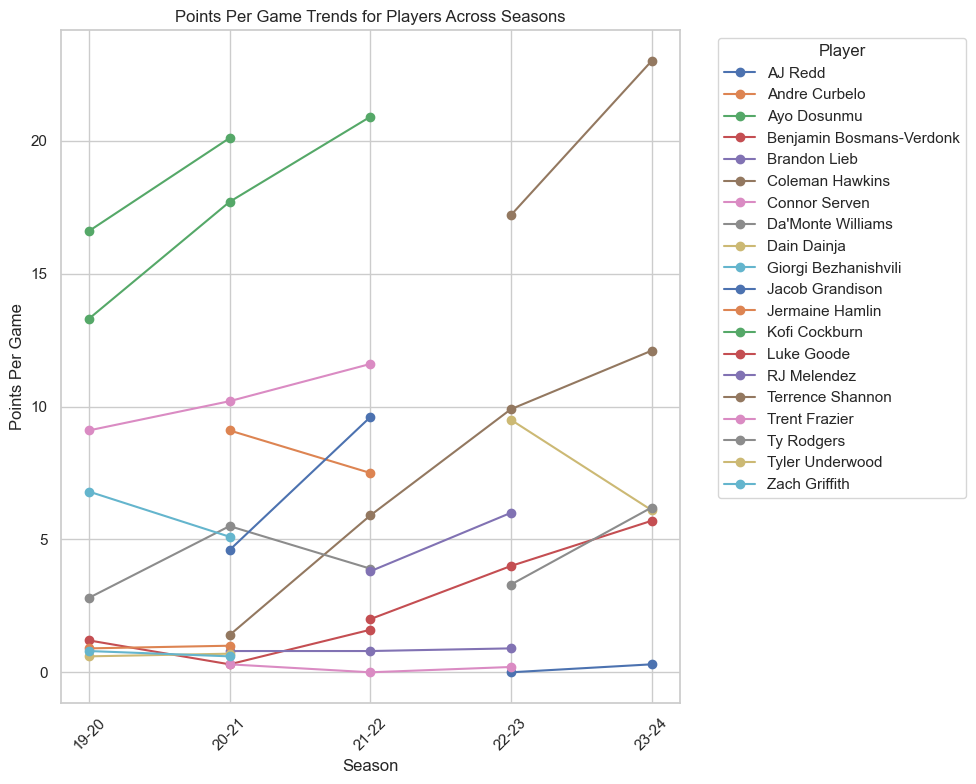

In [84]:
import warnings
warnings.filterwarnings('ignore') #mutes warnings for 2021 and 2122 

s1920 = ['19-20', '19-20', '19-20', '19-20', '19-20', '19-20', '19-20', 
         '19-20', '19-20', '19-20' , '19-20', '19-20', '19-20', '19-20']
roster_19_20['Season'] = s1920 # add season columns to rosters for analysis later

s2021 = ['20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21'
         '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21']
roster_20_21['Season'] = s2021
roster_20_21['Season'][6] = '20-21'

s2122 = ['21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22'
         '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22']
roster_21_22['Season'] = s2122
roster_21_22['Season'][6] = '21-22'


s2223 = ['22-23', '22-23', '22-23', '22-23', '22-23',
         '22-23', '22-23', '22-23', '22-23', '22-23', 
         '22-23', '22-23', '22-23', '22-23', '22-23']
roster_22_23['Season'] = s2223

s2324 = ['23-24', '23-24', '23-24', '23-24', '23-24', '23-24',
         '23-24', '23-24', '23-24', '23-24', '23-24', '23-24'
         ,'23-24']
roster_23_24['Season'] = s2324


all_rosters = pd.concat([roster_19_20, roster_20_21, roster_21_22, roster_22_23, roster_23_24], ignore_index= True)
count_players = all_rosters['Player'].value_counts()
multiple_season = count_players[count_players > 1].index.to_list()
attributes = ['Player', 'Season', 'PTS', 'AST']
roster_performance = all_rosters[all_rosters['Player'].isin(multiple_season)][attributes]
player_pts = roster_performance.pivot(index = 'Season', columns = 'Player', values = 'PTS')
plt.figure(figsize = (10,8))
player_pts
for player in player_pts.columns :
    plt.plot(player_pts.index, player_pts[player], marker = 'o', label = player)

plt.title('Points Per Game Trends for Players Across Seasons')
plt.xlabel('Season')
plt.ylabel('Points Per Game')
plt.xticks(rotation=45)
plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

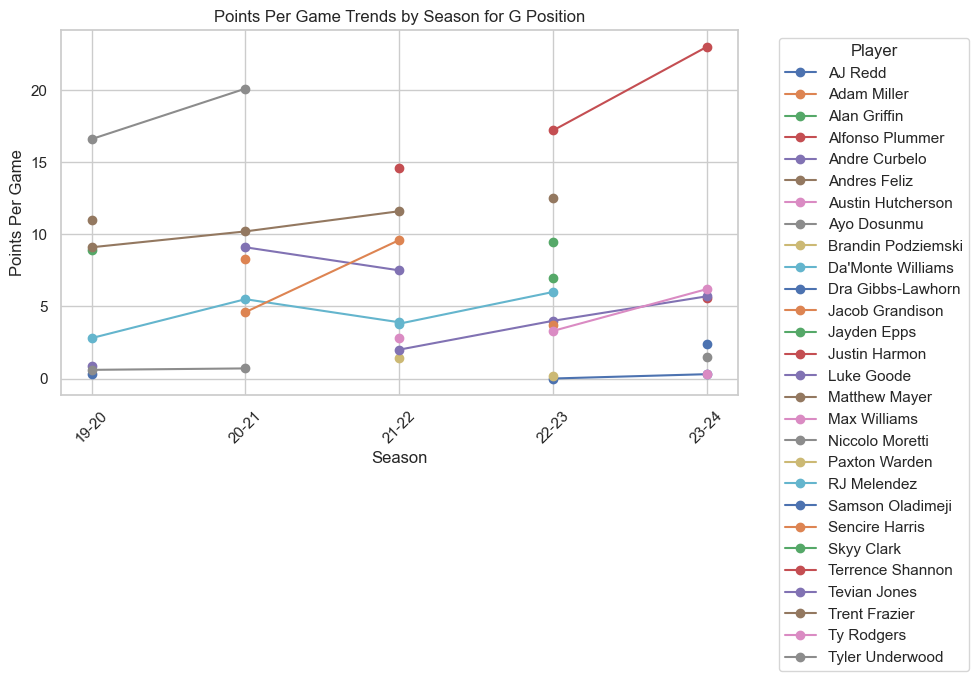

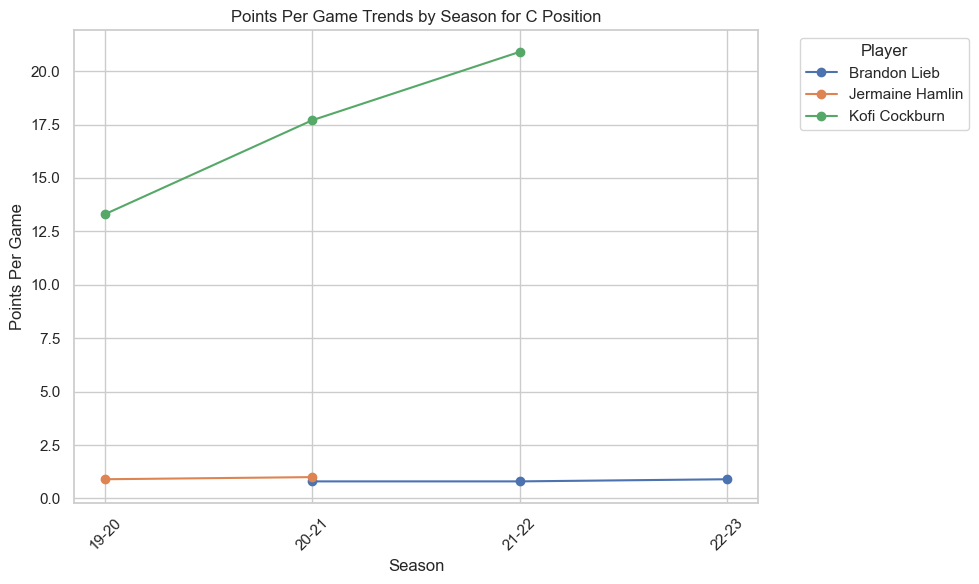

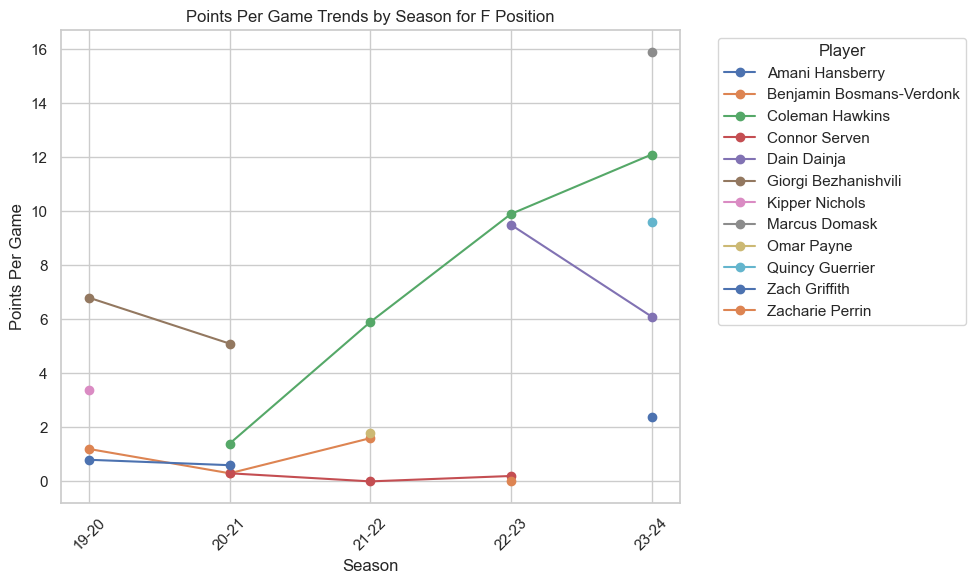

In [85]:
if 'Pos' in all_rosters.columns and 'PTS' in all_rosters.columns: 
    position = all_rosters['Pos'].unique()
    for pos in position:
        position_data = all_rosters[all_rosters['Pos'] == pos]
        pts_for_pos = position_data.pivot(index = 'Season', columns = 'Player', values = 'PTS')
        plt.figure(figsize = (10,6))
        for player in pts_for_pos.columns: 
            plt.plot(pts_for_pos.index, pts_for_pos[player], marker = 'o', label = player)
        plt.title(f'Points Per Game Trends by Season for {pos} Position')
        plt.xlabel('Season')
        plt.ylabel('Points Per Game')
        plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [86]:
#Code below makes a linear regression model predicting points based on various metrics 

all_rosters[['Feet', 'Inches']] = all_rosters['Height'].str.split('-', expand= True)
all_rosters['Feet'] = all_rosters['Feet'].astype(int)
all_rosters['Inches'] = all_rosters['Inches'].astype(int)
all_rosters['Height(inches)'] = all_rosters['Feet'] * 12 + all_rosters['Inches']
all_rosters.drop(columns = ['Unnamed: 0']) #converts the height to inches for linear regression model and also cleans it up a little
all_rosters['Predicted PTS'] = all_rosters['PTS']

In [87]:
x = all_rosters[['PTS', 'AST', 'Height(inches)', 'Weight']]
y = all_rosters['Predicted PTS']

drop_na = pd.concat([x, y], axis = 1).dropna()

x_c = drop_na[['PTS', 'AST', 'Height(inches)', 'Weight']]
y_c = drop_na['Predicted PTS']

x_train, x_test, y_train, y_test = train_test_split(x_c, y_c, test_size = 0.3, random_state = 42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
predictions

array([ 1.4, 16.6,  6. ,  8.9,  0.2,  8.3,  1.2,  5.9,  9.9,  0.8, 11.6,
        0.9,  9.6,  6.8,  4. , 14.6, 15.9,  3.9, 23. ,  0.8, 10.2,  7.5])

In [88]:
y_test

22     1.4
0     16.6
49     6.0
4      8.9
55     0.2
18     8.3
10     1.2
33     5.9
46     9.9
12     0.8
31    11.6
9      0.9
62     9.6
5      6.8
53     4.0
30    14.6
60    15.9
35     3.9
59    23.0
42     0.8
16    10.2
34     7.5
Name: Predicted PTS, dtype: float64

In [89]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("MSE = " + mse.astype(str) + "\n" + "R^2 = " + r2.astype(str))

MSE = 1.1641896344740043e-29
R^2 = 1.0


In [90]:
all_rosters

Player   # Class Pos Height  Weight  \
0                Ayo Dosunmu  11    SO   G    6-5   200.0   
1              Kofi Cockburn  21    FR   C    7-0   285.0   
2               Andres Feliz  10    SR   G    6-2   195.0   
3              Trent Frazier   1    JR   G    6-2   175.0   
4               Alan Griffin   0    SO   G    6-5   190.0   
5       Giorgi Bezhanishvili  15    SO   F    6-9   245.0   
6             Kipper Nichols   2    SR   F    6-6   220.0   
7          Da'Monte Williams  20    JR   G    6-3   215.0   
8            Jermaine Hamlin  34    FR   C   6-10   235.0   
9               Tevian Jones   5    SO   G    6-7   190.0   
10  Benjamin Bosmans-Verdonk  13    FR   F    6-8   235.0   
11           Tyler Underwood  32    JR   G    6-2   180.0   
12             Zach Griffith   4    JR   F    6-6   220.0   
13          Samson Oladimeji  35    SR   G    6-4   210.0   
14               Ayo Dosunmu  11    JR   G    6-5   200.0   
15             Kofi Cockburn  21    SO   C    7-0   285.0   
16             Trent Frazier   1    SR   G    6-2   175.0   
17             Andre Curbelo   5    FR   G    6-1   175.0   
18               Adam Miller  44    FR   G    6-3   180.0   
19         Da'Monte Williams  20    SR   G    6-3   215.0   
20      Giorgi Bezhanishvili  15    JR   F    6-9   245.0   
21           Jacob Grandison   3    JR   G    6-6   205.0   
22           Coleman Hawkins  33    FR   F   6-10   200.0   
23           Jermaine Hamlin  34    SO   C   6-10   235.0   
24           Tyler Underwood  32    SR   G    6-2   180.0   
25             Zach Griffith   4    SR   F    6-6   220.0   
26              Brandon Lieb  12    FR   C    7-0   210.0   
27  Benjamin Bosmans-Verdonk  13    SO   F    6-8   235.0   
28             Connor Serven   2    FR   F    6-9   215.0   
29             Kofi Cockburn  21    JR   C    7-0   285.0   
30           Alfonso Plummer  11    SR   G    6-1   182.0   
31             Trent Frazier   1    SR   G    6-2   175.0   
32           Jacob Grandison   3    SR   G    6-6   205.0   
33           Coleman Hawkins  33    SO   F   6-10   200.0   
34             Andre Curbelo   5    SO   G    6-1   175.0   
35         Da'Monte Williams  20    SR   G    6-3   215.0   
36               RJ Melendez  15    FR   G    6-7   205.0   
37                Omar Payne   4    JR   F   6-10   230.0   
38                Luke Goode  10    FR   G    6-7   200.0   
39  Benjamin Bosmans-Verdonk  13    JR   F    6-8   235.0   
40        Brandin Podziemski   0    FR   G    6-5   200.0   
41         Austin Hutcherson  22    SR   G    6-6   180.0   
42              Brandon Lieb  12    SO   C    7-0   210.0   
43             Connor Serven   2    SO   F    6-9   215.0   
44          Terrence Shannon   0    SR   G    6-6   210.0   
45             Matthew Mayer  24    SR   G    6-9   225.0   
46           Coleman Hawkins  33    JR   F   6-10   200.0   
47               Dain Dainja  42    SO   F    6-9   270.0   
48               Jayden Epps   3    FR   G    6-2   190.0   
49               RJ Melendez  15    SO   G    6-7   205.0   
50            Sencire Harris   1    FR   G    6-4   160.0   
51                Ty Rodgers  20    FR   G    6-6   200.0   
52                Skyy Clark  55    FR   G    6-3   200.0   
53                Luke Goode  10    SO   G    6-7   200.0   
54              Brandon Lieb  12    JR   C    7-0   210.0   
55             Paxton Warden  22    FR   G    6-4   180.0   
56             Connor Serven   2    JR   F    6-9   215.0   
57           Zacharie Perrin  25    FR   F   6-10     NaN   
58                   AJ Redd   5    FR   G    6-3   170.0   
59          Terrence Shannon   0    SR   G    6-6   210.0   
60             Marcus Domask   3    SR   F    6-6   215.0   
61           Coleman Hawkins  33    SR   F   6-10   200.0   
62           Quincy Guerrier  13    SR   F    6-7   220.0   
63                Ty Rodgers  20    SO   G    6-6   200.0   
64               Dain Dainja  42    JR   F    6-9   270.0

In [91]:
selected_columns = [
    'Player', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', 
    '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 
    'BLK', 'TOV', 'PTS', 'Height(inches)'
]

df_selected_outliers = all_rosters[selected_columns]
df_selected_outliers

Player Pos   G    GS    MP   FG   FGA    FG%   3P  3PA  \
0                Ayo Dosunmu   G  30  30.0  33.5  6.5  13.5  0.484  1.0  3.3   
1              Kofi Cockburn   C  31  31.0  27.4  4.9   9.2  0.532  0.0  0.0   
2               Andres Feliz   G  31  15.0  26.8  3.9   8.5  0.460  0.5  2.0   
3              Trent Frazier   G  31  30.0  30.5  2.8   8.5  0.327  1.6  5.3   
4               Alan Griffin   G  28   1.0  18.1  3.1   6.4  0.483  1.7  4.0   
5       Giorgi Bezhanishvili   F  31  24.0  23.2  2.7   6.3  0.429  0.4  1.2   
6             Kipper Nichols   F  31   1.0  13.8  1.3   3.5  0.383  0.1  0.6   
7          Da'Monte Williams   G  31  22.0  21.6  0.8   2.4  0.347  0.4  1.5   
8            Jermaine Hamlin   C  16   0.0   4.1  0.4   0.5  0.750  0.0  0.0   
9               Tevian Jones   G  14   0.0   4.8  0.3   1.7  0.167  0.2  1.1   
10  Benjamin Bosmans-Verdonk   F   9   0.0   6.2  0.4   1.2  0.364  0.0  0.2   
11           Tyler Underwood   G  14   1.0   3.4  0.1   0.6  0.222  0.1  0.4   
12             Zach Griffith   F   8   0.0   2.4  0.3   0.4  0.667  0.0  0.0   
13          Samson Oladimeji   G   8   0.0   2.0  0.1   0.4  0.333  0.0  0.3   
14               Ayo Dosunmu   G  28  28.0  35.1  7.5  15.4  0.488  1.1  2.9   
15             Kofi Cockburn   C  31  31.0  27.0  6.9  10.5  0.654  0.0  0.0   
16             Trent Frazier   G  31  31.0  33.7  3.2   7.9  0.400  1.8  4.9   
17             Andre Curbelo   G  31   0.0  21.5  3.5   7.1  0.498  0.2  1.0   
18               Adam Miller   G  31  31.0  25.5  2.9   7.4  0.391  1.7  4.9   
19         Da'Monte Williams   G  31  17.0  24.9  1.7   3.3  0.515  1.1  2.1   
20      Giorgi Bezhanishvili   F  31   0.0  14.5  2.2   4.0  0.545  0.1  0.2   
21           Jacob Grandison   G  30  16.0  15.3  1.7   3.2  0.526  0.6  1.4   
22           Coleman Hawkins   F  25   0.0   6.3  0.4   1.2  0.345  0.1  0.5   
23           Jermaine Hamlin   C   8   0.0   3.0  0.3   0.4  0.667  0.0  0.0   
24           Tyler Underwood   G   7   0.0   2.3  0.3   0.4  0.667  0.1  0.1   
25             Zach Griffith   F   7   1.0   3.1  0.3   0.3  1.000  0.0  0.0   
26              Brandon Lieb   C   5   0.0   2.4  0.2   1.4  0.143  0.0  0.0   
27  Benjamin Bosmans-Verdonk   F   8   0.0   2.3  0.1   0.4  0.333  0.0  0.0   
28             Connor Serven   F   7   0.0   1.9  0.1   0.1  1.000  0.0  0.0   
29             Kofi Cockburn   C  28  28.0  30.7  8.1  13.6  0.593  0.0  0.0   
30           Alfonso Plummer   G  33  29.0  30.2  4.7  11.0  0.424  3.0  7.3   
31             Trent Frazier   G  31  30.0  34.7  3.9   9.8  0.397  2.0  6.2   
32           Jacob Grandison   G  30  23.0  25.0  3.4   7.5  0.455  1.8  4.5   
33           Coleman Hawkins   F  33  14.0  19.0  2.1   4.7  0.442  0.6  2.0   
34             Andre Curbelo   G  19   4.0  19.3  2.6   7.8  0.329  0.3  1.8   
35         Da'Monte Williams   G  33  30.0  28.8  1.3   4.2  0.307  0.8  2.4   
36               RJ Melendez   G  22   1.0   8.5  1.3   2.3  0.569  0.4  0.7   
37                Omar Payne   F  32   3.0   7.4  0.7   1.1  0.618  0.0  0.0   
38                Luke Goode   G  28   0.0   8.9  0.6   2.0  0.327  0.6  1.5   
39  Benjamin Bosmans-Verdonk   F  24   2.0   7.8  0.7   1.5  0.472  0.0  0.0   
40        Brandin Podziemski   G  16   0.0   4.3  0.5   1.2  0.421  0.2  0.8   
41         Austin Hutcherson   G   4   1.0  15.3  0.8   2.0  0.375  0.0  1.0   
42              Brandon Lieb   C  10   0.0   2.4  0.4   0.5  0.800  0.0  0.0   
43             Connor Serven   F   6   0.0   2.0  0.0   0.2  0.000  0.0  0.2   
44          Terrence Shannon   G  31  30.0  32.1  5.1  11.6  0.442  1.6  5.0   
45             Matthew Mayer   G  33  33.0  26.6  4.0   9.9  0.407  2.0  6.2   
46           Coleman Hawkins   F  33  33.0  32.5  3.7   8.5  0.441  1.1  4.0   
47               Dain Dainja   F  33  21.0  20.5  4.0   6.2  0.636  0.0  0.0   
48               Jayden Epps   G  31  11.0  24.6  3.6   8.6  0.414  1.2  4.0   
49               RJ Me

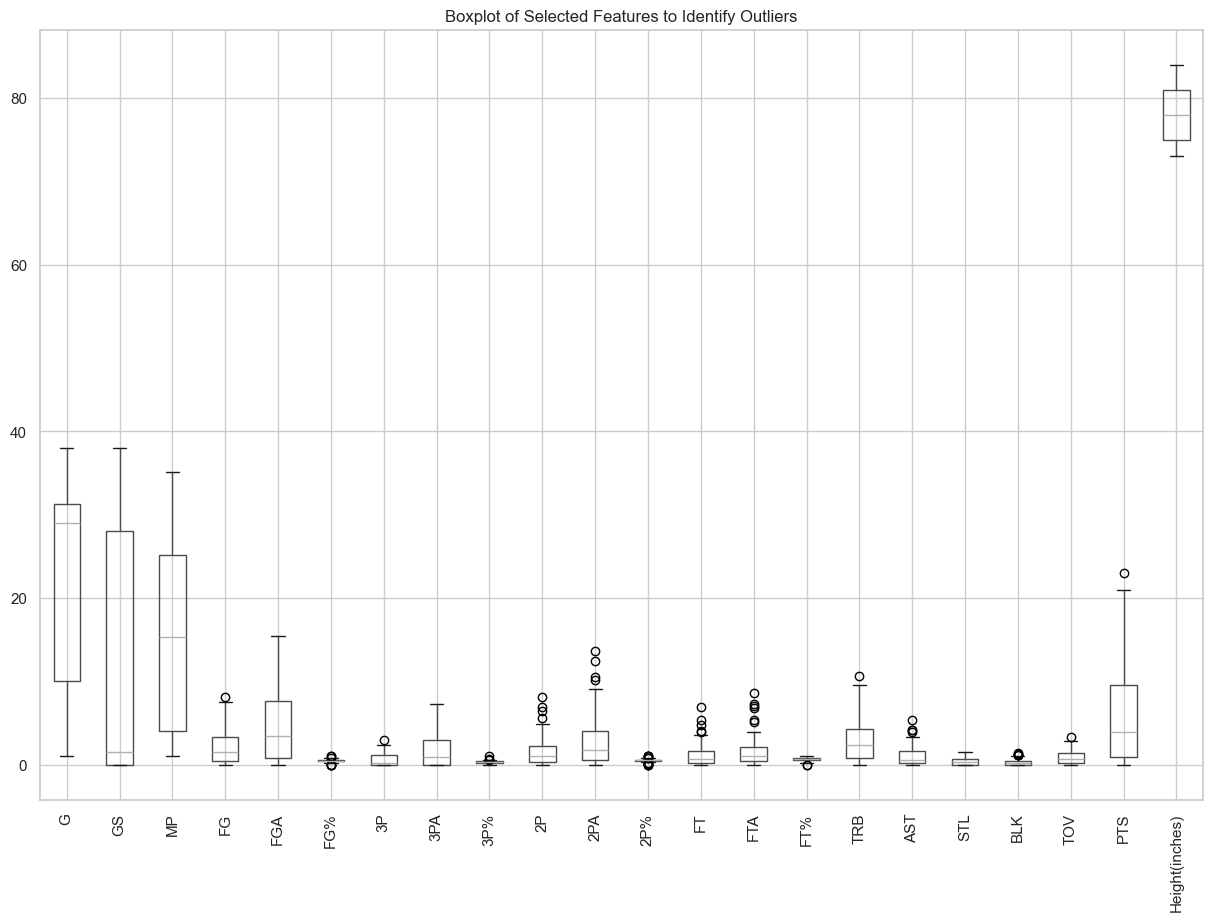

In [92]:
# looking for outliers within specific features

plt.figure(figsize=(15, 10))
df_selected_outliers.boxplot()
plt.xticks(rotation = 90) 
plt.title("Boxplot of Selected Features to Identify Outliers")
plt.show()

In [93]:
from scipy.stats import zscore

z_scores = df_selected_outliers.select_dtypes(include=['float64', 'int']).apply(zscore)

outliers = (z_scores.abs() > 3).any(axis=1)
df_outliers = df_selected_outliers[outliers]
df_outliers

Player Pos   G    GS    MP   FG   FGA    FG%   3P  3PA    3P%  \
1      Kofi Cockburn   C  31  31.0  27.4  4.9   9.2  0.532  0.0  0.0  0.000   
14       Ayo Dosunmu   G  28  28.0  35.1  7.5  15.4  0.488  1.1  2.9  0.390   
15     Kofi Cockburn   C  31  31.0  27.0  6.9  10.5  0.654  0.0  0.0    NaN   
29     Kofi Cockburn   C  28  28.0  30.7  8.1  13.6  0.593  0.0  0.0    NaN   
30   Alfonso Plummer   G  33  29.0  30.2  4.7  11.0  0.424  3.0  7.3  0.408   
44  Terrence Shannon   G  31  30.0  32.1  5.1  11.6  0.442  1.6  5.0  0.321   
59  Terrence Shannon   G  32  31.0  33.9  6.8  14.4  0.475  2.4  6.7  0.362   

     2P   2PA    2P%   FT  FTA    FT%   TRB  AST  STL  BLK  TOV   PTS  \
1   4.9   9.1  0.534  3.6  5.3  0.677   8.8  0.6  0.5  1.4  1.9  13.3   
14  6.4  12.4  0.511  4.0  5.1  0.783   6.3  5.3  1.1  0.2  3.3  20.1   
15  6.9  10.5  0.654  3.9  7.0  0.553   9.5  0.2  0.3  1.3  1.7  17.7   
29  8.1  13.6  0.593  4.8  7.3  0.655  10.6  0.8  0.8  1.0  2.3  20.9   
30  1.7   3.7  0.455  2.3  2.6  0.874   2.5  1.1  0.3  0.0  1.3  14.6   
44  3.5   6.6  0.534  5.4  6.8  0.790   4.6  2.8  1.3  0.5  2.6  17.2   
59  4.4   7.8  0.573  6.9  8.6  0.801   4.0  2.3  1.0  0.9  2.0  23.0   

    Height(inches)  
1               84  
14              77  
15              84  
29              84  
30              73  
44              78  
59              78

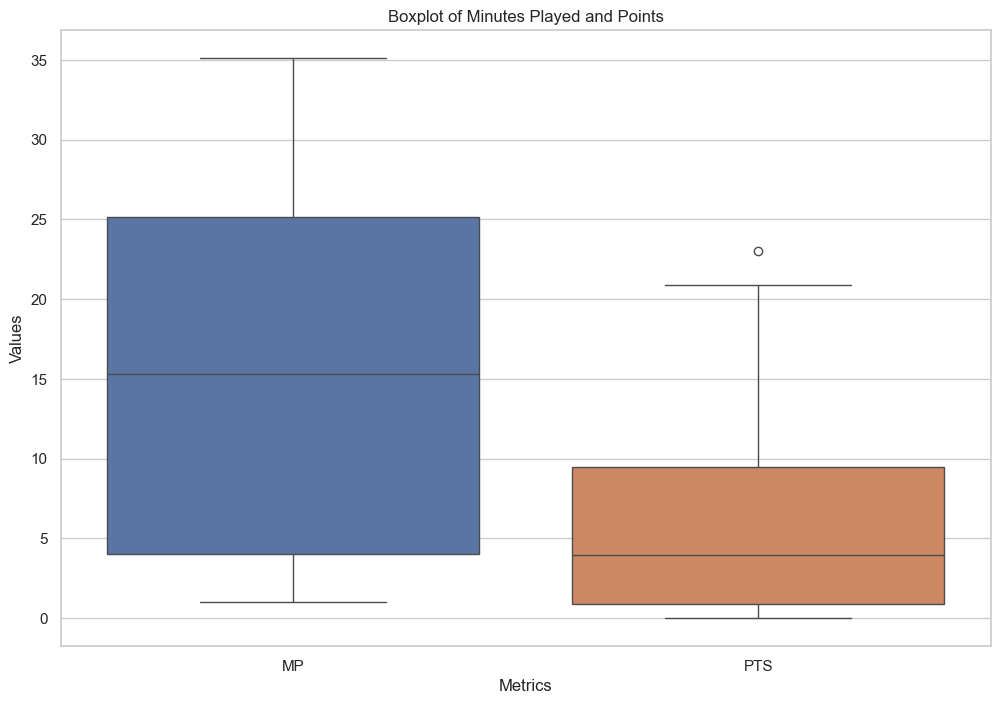

In [94]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected_outliers[['MP', 'PTS']])
plt.title("Boxplot of Minutes Played and Points")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.show()

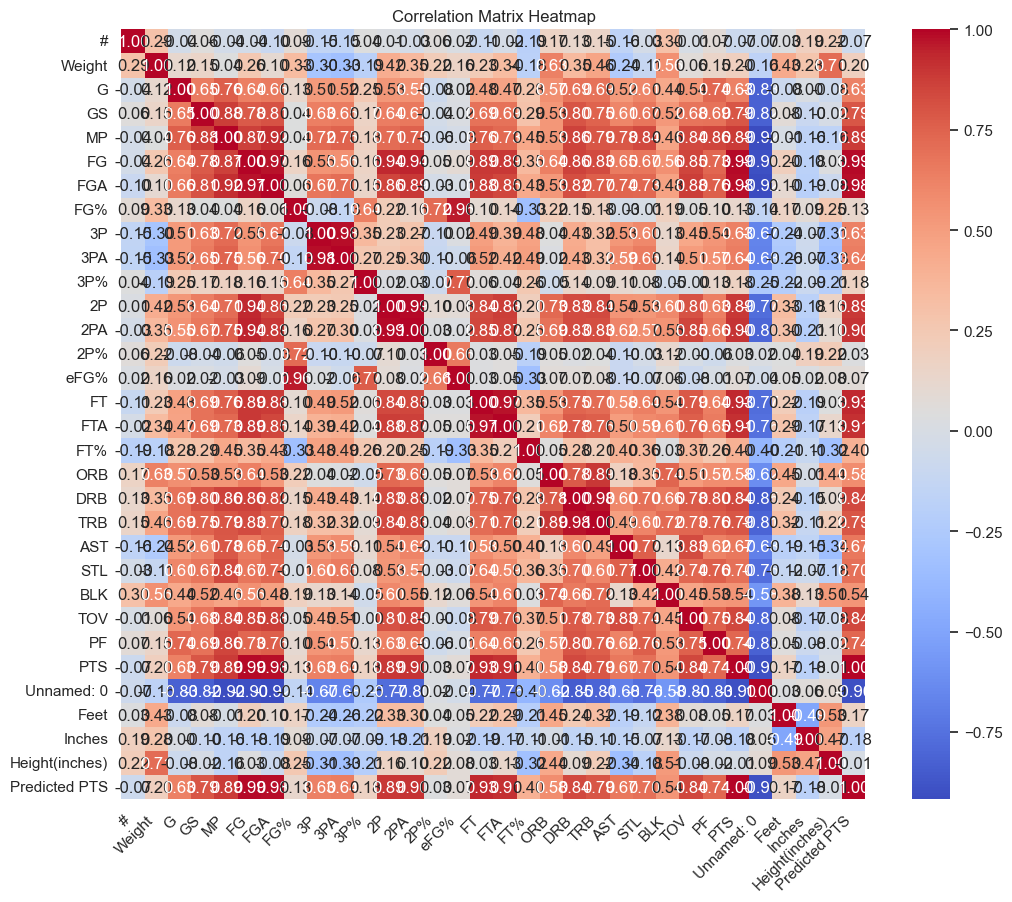

In [95]:
numeric_roster = all_rosters.select_dtypes(include=[np.number])
corr = numeric_roster.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap')
plt.show()